## FedAVG
- dataset: 
    - MNIST/ CIFAR10
    - stock?
    
<!-- <img src="slide_image/FedAvg_MNIST.png" width=640  /> -->


In [ ]:
# %%writefile test.py 
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--rounds", help="aggregation rounds",
                    type=int)
args = parser.parse_args()

rounds_ = args.rounds
if not rounds_:
    raise ValueError('***Plz type in aggregation rounds***')
# print(rounds)



## Importing

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D)
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Custom func.

In [3]:
def simplecnn(name):
    # 選擇 Keras 的 API 寫法
    inputs = Input(shape=(28,28,1))

    # 第一層
    # 建立卷積層，設定32個3*3的filters
    # 設定ReLU為激活函數。
    x = Conv2D(32, (3, 3), activation='relu')(inputs)

    # 第二層 - 卷積層 + 池化層
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 第三層 - 卷積層
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # 第四層 - 卷積層 + 池化層
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 建立分類模型 (MLP) : 平坦層 + 輸出層 (10)
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    cnn_model = Model(inputs=inputs, outputs=outputs)
    return cnn_model

In [4]:
def model_trainable(model, under):
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[under:]:
        layer.trainable = True
        
    for i in model.layers:
        print(i.trainable)

## Training

### data gathering

In [5]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test_origin, y_test_origin) = mnist.load_data()

# 標準化數據
X_train = X_train/255.0
X_test_origin = X_test_origin/255.0
print(X_train.shape)
print(X_train[0].shape)

(60000, 28, 28)
(28, 28)


In [6]:
idx = np.argsort(y_train)
x_train_sorted = X_train[idx]
y_train_sorted = y_train[idx]



### Initial Model 

In [7]:
model = simplecnn('server_model')

### aggregation func.

In [8]:
from tensorflow.keras.models import clone_model

def avg_weight(choice, Gmodel, client_list):
    tmp_model = clone_model(Gmodel) # Gmdoel  
    tmp_model.set_weights(Gmodel.get_weights()) # Gmdoel servermodel
    models = []
    weighting = []
    for _ in choice: # idx of selected client
        models.append(client_list['client'+str(_)].model)
        weighting.append(len(client_list['client'+str(_)].data))
        
    weights = [model.get_weights() for model in models]
    new_weights = list()
    
    weighting = np.array(weighting)/np.sum(weighting)

    weights = [i for i in weights]
    
    for i in zip(*weights):
        a = np.average(i, weights=weighting, axis=0)
        new_weights.append(a)
    
    pt = 0
    for i in range(len(tmp_model.layers)):
        a = tmp_model.layers[i]

        if len(a.get_weights()) != 0:
            a.set_weights(new_weights[pt:len(a.get_weights())+pt])
            pt+=len(a.get_weights())
    del models, weighting, new_weights
    return tmp_model


In [9]:
def model_check(model_1, model_2):
    a = model_1.get_weights()
    for i in range(len(a)):
#         print(i)
        if np.array_equal(model_1.get_weights()[i], model_2.get_weights()[i]):
            print('layer %d is equal'%i)
            pass
        else:
#             print('Model not equal')
            print('layer %d is not equal'%i)
    


## Initial Client 

### Define clinet 

In [10]:
class clint_k():
    
    def __init__(self, name):
        self.name = name
        
        self.attri = {'name':self.name}
    def set_content(self, data, label, model):
        content = {'name': self.name, 'data':data, 'label':label, 'model':model}
        self.data = data
        self.label = label
        self.model = model
        values_list = [self.name, self.data, self.label, self.model]
        keys_list = ['name','data', 'label', 'model']
        self.attri = dict(zip(keys_list, values_list))
        return content
    def show_content(self):

        return self.attri

### stuff data, model into client

In [11]:
from utils import *

def split_client(x, y, method = bySample_bal_split, K = 6):
    
#     hyper_para['K'] 
    K = K

    split_method = {}
    # split_method['method'] = lambda x,y,k : byClasses_inbal_split(x,y,k)
    split_method['method'] = bySample_bal_split


    subset= split_method['method'](x_train_sorted, y_train_sorted, K)
    view_clientDict(subset)
    return subset
    
# _ = split_client(x_train_sorted, y_train_sorted, bySample_bal_split, 4)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_, y_train_))
train_dataset = train_dataset.shuffle(buffer_size=1024).prefetch(batch_size).batch(batch_size)

>>> 分割給 4 個client
>>> subset client0 資料維度
-- data shape (15000, 28, 28) --label shape (15000,)
>>> subset client3 資料維度
-- data shape (15000, 28, 28) --label shape (15000,)


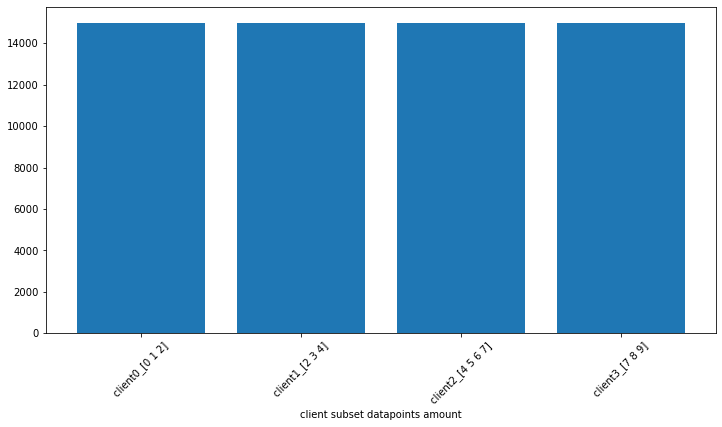

dict_keys(['client0', 'client1', 'client2', 'client3'])


In [12]:
from tensorflow.keras.models import clone_model


Gmodel = simplecnn('server_model')

hyper_para = dict()
hyper_para['K'] = 4
subset = split_client(x_train_sorted, y_train_sorted, bySample_bal_split, hyper_para['K'])

client_list = dict() 

for _ in list(subset.keys()):

    client_list[_] = clint_k(_)
    client_list[_].set_content(data = subset[_][0], # setting data and weight
                               label = subset[_][1], model = clone_model(Gmodel))
    client_list[_].model.set_weights(Gmodel.get_weights())
print(client_list.keys())


### start training

In [13]:
import numpy as np
# batchsize
hyper_para['B'] = 1024

# choice
# C = 1
hyper_para['C'] = 0.5

# Epochs
hyper_para['E'] = 3

hyper_para['mu'] = 0


print(hyper_para)

{'K': 4, 'B': 1024, 'C': 0.5, 'E': 3, 'mu': 0}


In [14]:
# from sklearn.metrics import accuracy_score
# import numpy as np
    
# def acc_model(X_test, y_test, model, num):

    
#     a = np.random.choice(len(X_test), num)
# #     print(a)
#     y_pred = model.predict(X_test[a])
#     y_pred = np.argmax(y_pred,axis=1)
#     print(y_pred[0:10])
#     y_true = y_test[a]
#     print(y_true[0:10])
# #     print(accuracy_score(y_true, y_pred))
#     return accuracy_score(y_true, y_pred)

In [15]:
# a = Gmodel.weights[0]
# tf.norm(a)
# tf.norm([tf.norm(a) for a in Gmodel.weights])
# # tf.norm(b, axis=[-2,-1])

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time

acc_test = []

if not 'rounds_' in list(locals().keys()):
    rounds_ = 10
for rounds in range(rounds_):
    print(rounds)
    clients = range(hyper_para['K'])
    
    size = int(np.ceil(hyper_para['C']*hyper_para['K']))
    choice = np.random.choice(clients, size = size, replace=False)


    #--------------------
    batch_size = hyper_para['B']
    epochs = hyper_para['E']
    u = hyper_para['mu']


    for _ in choice:
        print('*************************************')
        print('Training on client'+str(_))
        client = client_list['client'+str(_)]

        
        model = client.model
        
        # Instantiate an optimizer to train the model.
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        # Instantiate a loss function.
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        # Prepare the metrics.
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
#         val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        

        X_train_, X_test_, y_train_, y_test_ = train_test_split(
                client.data, client.label, test_size=0.1)


        # Prepare the training dataset.
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_, y_train_))
#         train_dataset = train_dataset.shuffle(buffer_size=1024).prefetch(batch_size).batch(batch_size)
        train_dataset = train_dataset.shuffle(buffer_size=1024).prefetch(batch_size).batch(batch_size)
        
#         train_acc = []
        
        #------------------------------------------
        start_time = time.time()
        for epoch in range(epochs):
#             print('epoch = ',epoch)
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

                # Open a GradientTape to record the operations run
                # during the forward pass, which enables auto-differentiation.
                with tf.GradientTape(persistent=True) as tape:

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.
                    logits = model(x_batch_train, training=True)  # Logits for this minibatch

                    # Compute the loss value for this minibatch.
                    loss_value = loss_fn(y_batch_train, logits)
#                     print(loss_value)


                    ## proximal term ========================================================
                    weights = [model.get_weights() for model in [model, Gmodel]]
                    new_weights = list()

                    for weights_list_tuple in zip(*weights):
                        new_weights.append(
                            [np.subtract(weights_[0], weights_[1])\
                                for weights_ in zip(*weights_list_tuple)])
                    weight_diff = new_weights
                    diff_2norm =  tf.norm([tf.norm(a) for a in weight_diff])

                    
                    proximal_term = 0.5*u*diff_2norm
                    loss_value+=proximal_term
                ## proximal term End ========================================================
    
                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)
                
                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
            
                # Update training metric.
                train_acc_metric.update_state(y_batch_train, logits)
                
                
            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))
#             train_acc.append(float(train_acc)) # 取得 acc
            
            # Reset training metrics at the end of each epoch
            train_acc_metric.reset_states()
        
            
        
        print("Time taken: %.2fs" % (time.time() - start_time))
        #----------------------------------
        
    
    Gmodel = avg_weight(choice, Gmodel, client_list)
    for i in client_list:
        client_list[i].model.set_weights(Gmodel.get_weights()) 

        
        
    # Prepare the global validation dataset. 
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test_origin, y_test_origin))
    val_dataset = val_dataset.batch(batch_size//10)
    
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
#     if rounds % 5 == 0:
        
    for x_batch_val, y_batch_val in val_dataset:
            val_logits = Gmodel(x_batch_val, training=False)
            # Update val metrics
            val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Global model Validation acc on global valdation set: %.4f" % (float(val_acc),))

    acc_test.append(float(val_acc))
    


0
*************************************
Training on client3
Training acc over epoch: 0.4310
Training acc over epoch: 0.7375
Training acc over epoch: 0.7641
Time taken: 4.07s
*************************************
Training on client1
Training acc over epoch: 0.6236
Training acc over epoch: 0.7453
Training acc over epoch: 0.7518
Time taken: 2.51s
Global model Validation acc on global valdation set: 0.2112
1
*************************************
Training on client2
Training acc over epoch: 0.0697
Training acc over epoch: 0.2376
Training acc over epoch: 0.2429
Time taken: 2.51s
*************************************
Training on client1
Training acc over epoch: 0.7217
Training acc over epoch: 0.7501
Training acc over epoch: 0.7533
Time taken: 2.51s
Global model Validation acc on global valdation set: 0.1542
2
*************************************
Training on client0
Training acc over epoch: 0.0081
Training acc over epoch: 0.1561
Training acc over epoch: 0.8218
Time taken: 2.51s
**************

In [17]:
import pandas as pd
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df = pd.DataFrame(acc_test, columns=['Gmodel acc'])

df['hyper_keys'] = pd.DataFrame(hyper_para.keys())
df['hyper_item'] = pd.DataFrame(hyper_para.values())


df.to_csv('./data/acc_test_'+timestr+'.csv', index=False)